In [1]:
import openai
import pandas as pd
import time

/Applications/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
client = openai.OpenAI(api_key="{insert api key}")
response = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[{"role": "user", "content": "Say 'Hello, world!'"}]
)
print(response.choices[0].message.content)


Hello, world!


In [31]:
def classify_news(article_text, model="gpt-4-turbo"):
    """Calls OpenAI API to classify a news article as real (1) or fake (0)."""
    if not isinstance(article_text, str) or article_text.strip() == "":
        return None  # Avoid sending empty or invalid requests
    
    prompt = (
        f"""Determine whether the following news article is real (1) or fake (0). 
        Provide only the number 1 or 0 as output.
        
        Article:
        {article_text}
        """
    )
    
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "system", "content": "You are a fact-checking AI."},
                      {"role": "user", "content": prompt}],
            temperature=0
        )
        prediction = response.choices[0].message.content.strip()
        return int(prediction) if prediction in ["0", "1"] else None
    except Exception as e:
        print(f"Error processing article: {e}")
        return None

def process_news_file(input_file, output_file):
    """Reads a CSV file, classifies news articles, updates rows, and calculates accuracy."""
    df = pd.read_csv(input_file, low_memory=False)
    
    if "text" not in df.columns or "original label" not in df.columns:
        raise ValueError("CSV file must contain 'text' and 'original label' columns.")
    
    # Initialize an empty list for predictions
    predictions = []
    
    for index, row in df.iterrows():
        gpt_label = classify_news(row["text"])
        predictions.append(gpt_label)
        df.at[index, "gpt labels"] = gpt_label  # Update row immediately
    
    # Drop rows where GPT didn't return a valid prediction
    df.dropna(subset=["gpt labels"], inplace=True)
    
    # Ensure GPT predictions are integers
    df["gpt labels"] = df["gpt labels"].astype(int)
    
    # Save the updated dataframe immediately
    df.to_csv(output_file, index=False, encoding="utf-8")
    print(f"Results saved to {output_file}")

def evaluate_metrics(processed_file):
    """Evaluates precision, recall, and F1-score for the GPT predictions from scratch."""
    df = pd.read_csv(processed_file)
    
    if "gpt labels" not in df.columns or "original label" not in df.columns:
        raise ValueError("Processed CSV file must contain 'gpt labels' and 'original label' columns.")
    
    true_positives = sum((df["gpt labels"] == 1) & (df["original label"] == 1))
    false_positives = sum((df["gpt labels"] == 1) & (df["original label"] == 0))
    false_negatives = sum((df["gpt labels"] == 0) & (df["original label"] == 1))
    true_negatives = sum((df["gpt labels"] == 0) & (df["original label"] == 0))
    
    accuracy = (true_positives + true_negatives) / len(df)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1 Score: {f1:.2%}")

In [32]:
if __name__ == "__main__":
    input_file = "../data/news_data.csv"
    output_file = "ISOT_Data_With_LLM_Predictions.csv"
    process_news_file(input_file, output_file)
    evaluate_metrics(output_file)

Results saved to news_data_with_predictions.csv
Accuracy: 88.00%
Precision: 82.76%
Recall: 96.00%
F1 Score: 88.89%


In [2]:
df = pd.read_csv("../LLM Results/ISOT_Data_With_LLM_Predictions.csv")
df

,title,text,subject,date,original label,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 163,Unnamed: 164,Unnamed: 165,Unnamed: 166,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,gpt labels
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Second U.S. judge blocks Trump administration ...,SAN FRANCISCO (Reuters) - A second U.S. judge ...,politicsNews,"December 21, 2017",1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
96,Senators seek to stop expansion of airport fac...,WASHINGTON (Reuters) - Two U.S. senators on Th...,politicsNews,"December 21, 2017",1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
97,U.S. launches effort to reduce reliance on imp...,WASHINGTON (Reuters) - U.S. Interior Secretary...,politicsNews,"December 21, 2017",1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
98,"Short-term government funding, disaster aid bi...",WASHINGTON (Reuters) - The U.S. House of Repre...,politicsNews,"December 21, 2017",1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Confirm expected columns are present
assert "gpt labels" in df.columns and "original label" in df.columns, "Missing required columns."

# Extract true and predicted labels
y_true = df["original label"]
y_pred = df["gpt labels"]
accuracy = round(accuracy_score(y_true, y_pred), 5)
# Print evaluation
print("\n=== GPT Model Performance ===")
print("Accuracy:", accuracy)
print(classification_report(y_true, y_pred, digits=5))



=== GPT Model Performance ===
Accuracy: 0.88
              precision    recall  f1-score   support

         0.0    0.95238   0.80000   0.86957        50
         1.0    0.82759   0.96000   0.88889        50

    accuracy                        0.88000       100
   macro avg    0.88998   0.88000   0.87923       100
weighted avg    0.88998   0.88000   0.87923       100



<Figure size 640x480 with 0 Axes>

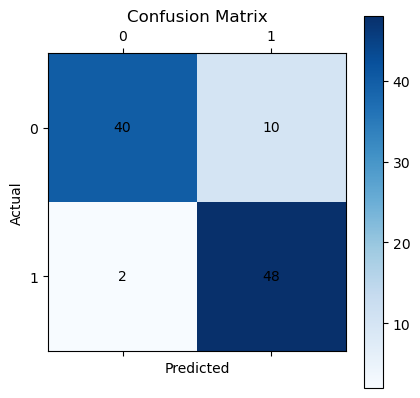

In [12]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure()
plt.matshow(conf_matrix, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.grid(False)
for (i, j), value in np.ndenumerate(conf_matrix):
    plt.text(j, i, f'{value}', ha='center', va='center')
plt.show()